In [1]:
import sys
sys.path.append("../..")
import torch
import numpy as np
import matplotlib.pyplot as plt
from data_utils      import *
from model_utils     import get_network
from tqdm import tqdm
from pyhessian import hessian
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Wrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)[-1]

# create dataloaders
channel, im_size, train_n_classes, test_n_classes, dst_train, dst_test = get_dataset(
        "CIFAR10",
        "../../data",
        zca=False
    )
assert train_n_classes == test_n_classes
train_loader = torch.utils.data.DataLoader(dst_train, batch_size=256, shuffle=True, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
data = torch.load(f"../../DD_data/0.pt")
synthetic_data = data["data"].cuda()
synthetic_label = data["label"].cuda()
data = torch.load(f"../../DD_data/1.pt")
synthetic_data2 = data["data"].cuda()
synthetic_label2 = data["label"].cuda()
data = torch.load(f"../../DD_data/2.pt")
synthetic_data3 = data["data"].cuda()
synthetic_label3 = data["label"].cuda()
data = torch.load(f"../../DD_data/3.pt")
synthetic_data4 = data["data"].cuda()
synthetic_label4 = data["label"].cuda()

In [7]:
model = Wrapper(get_network("ConvNet", 3, 10, (32,32))).cuda()
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
model.train()

trace_train = []
trace_distilled = []
trace_distilled2 = []
trace_distilled3 = []
trace_distilled4 = []
counter = 0
broken = False
with tqdm(total=301, desc="Training Progress", unit="iteration") as pbar:
    for _ in range(2):
        for x,y in train_loader:
            hessian_comp = hessian(model, criterion, dataloader=train_loader, cuda=True)
            trace_train.append(np.mean(hessian_comp.trace()).item())
            hessian_comp = hessian(model, criterion, data=(synthetic_data, synthetic_label), cuda=True)
            trace_distilled.append(np.mean(hessian_comp.trace()).item())
            hessian_comp = hessian(model, criterion, data=(synthetic_data2, synthetic_label2), cuda=True)
            trace_distilled2.append(np.mean(hessian_comp.trace()).item())
            hessian_comp = hessian(model, criterion, data=(synthetic_data3, synthetic_label3), cuda=True)
            trace_distilled3.append(np.mean(hessian_comp.trace()).item())
            hessian_comp = hessian(model, criterion, data=(synthetic_data4, synthetic_label4), cuda=True)
            trace_distilled4.append(np.mean(hessian_comp.trace()).item())
            
            counter += 1
            pbar.update(1)
            if counter == 301:
                broken = True
                break

            x = x.cuda()
            y = y.cuda()
            loss = criterion(model(x), y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        if broken:
            break


Training Progress: 100%|██████████████████████████████████████████████████████████| 301/301 [10:35:10<00:00, 126.61s/iteration]


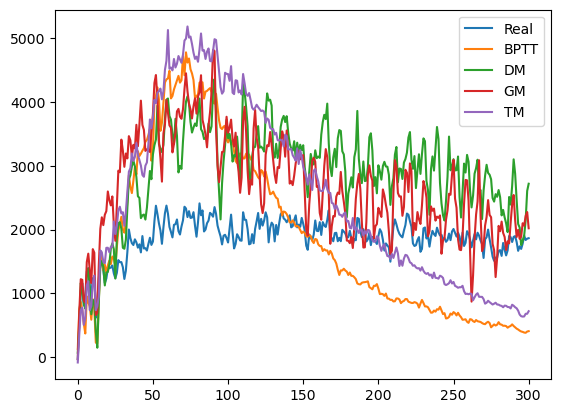

In [10]:
plt.plot(np.arange(301), trace_train, label='Real')
plt.plot(np.arange(301), trace_distilled, label='BPTT')
plt.plot(np.arange(301), trace_distilled2, label='DM')
plt.plot(np.arange(301), trace_distilled3, label='GM')
plt.plot(np.arange(301), trace_distilled4, label='TM')
plt.legend()

In [11]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

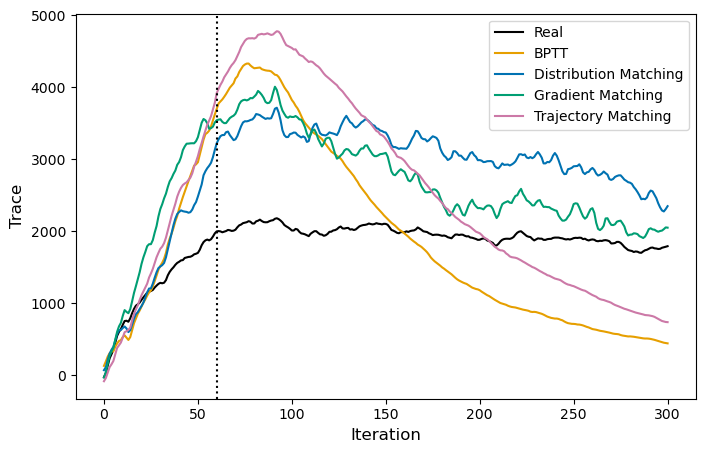

In [12]:
plt.figure(figsize=(8,5))
colours = ["#000000", "#E69F00", "#0072B2", "#009E73", "#CC79A7"]
plt.plot(np.arange(301), smooth(trace_train, 0.9), label='Real', c=colours[0])
plt.plot(np.arange(301), smooth(trace_distilled, 0.9), label='BPTT', c=colours[1])
plt.plot(np.arange(301), smooth(trace_distilled2, 0.9), label='Distribution Matching', c=colours[2])
plt.plot(np.arange(301), smooth(trace_distilled3, 0.9), label='Gradient Matching', c=colours[3])
plt.plot(np.arange(301), smooth(trace_distilled4, 0.9), label='Trajectory Matching', c=colours[4])
plt.ylabel("Trace", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.axvline(x=60, color='black', linestyle=':')
plt.legend()